In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/EIP4/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [1]:
#%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import plot_model
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D, BatchNormalization, Activation, AveragePooling2D
from keras.regularizers import l2
import os
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.callbacks import *

Using TensorFlow backend.


In [2]:
# load annotations
#df = pd.read_csv("/content/gdrive/My Drive/assignment5_data/hvc_data.zip (Unzipped Files)/hvc_annotations.csv")
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):

  """
  p : the probability that random erasing is performed
  s_l, s_h : minimum / maximum proportion of erased area against input image
  r_1, r_2 : minimum / maximum aspect ratio of erased area
  v_l, v_h : minimum / maximum value for erased area
  pixel_level : pixel-level randomization for erased area
  """

  def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img

  return eraser

In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.2, random_state = 1)
train_df.shape, val_df.shape

((10858, 28), (2715, 28))

In [7]:
train_df

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
1711,resized/1712.jpg,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
12377,resized/12379.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0
8153,resized/8154.jpg,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
7911,resized/7912.jpg,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
554,resized/555.jpg,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,resized/906.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
5192,resized/5193.jpg,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
12172,resized/12174.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
235,resized/236.jpg,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0


In [0]:
# create train and validation data generators

train_gen = PersonDataGenerator(train_df, 
                                batch_size= 8, 
                                augmentation=ImageDataGenerator(
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    rotation_range=30,
                                    zoom_range=[0.5,1.0],
                                    preprocessing_function=get_random_eraser(v_l=0, v_h=1)
                                ))
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)


In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}

In [0]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    """
    lr = 1e-3
    #lr = 1.0
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    """
    lr = 0.0001
    if epoch > 95:
        lr = 0.000001
    if epoch > 80:
        lr = 0.00005
    elif epoch > 60:
        lr = 0.0001
    elif epoch > 40:
        lr = 0.0005
    elif epoch > 20:
        lr = 0.001
    print('Learning rate: ', lr)
    return lr

In [0]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
    

def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    

clr = CyclicLR(base_lr=0.001, max_lr=0.007,
                        step_size=300., mode='exp_range',
                        gamma=0.99994)

In [0]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(6):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=1)(x)
    #y = Flatten()(x)
    y = (x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model













Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
________________________________________________________________________________

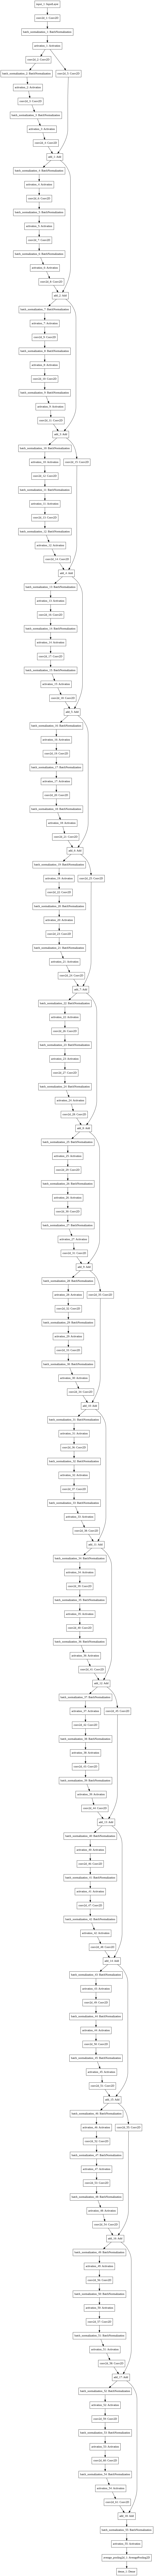

In [15]:
input_shape = (224, 224, 3)
resnet_v2_x1 = resnet_v2(input_shape=input_shape, depth=depth)
'''model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])'''
resnet_v2_x1.summary()
print(model_type)
from keras.utils import plot_model
plot_model(resnet_v2_x1)

In [16]:
# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
save_dir = '/content/gdrive/My Drive/saved models/'
#model_name = 'assign5_%s_model.{epoch:03d}.h5' % model_type
model_name = 'assign5_resnet50_i1.{epoch:03d}.h5'

print(save_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

print(filepath)

/content/gdrive/My Drive/saved models/
/content/gdrive/My Drive/saved models/assign5_resnet50_i1.{epoch:03d}.h5


In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

#lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, clr]

Inputs :  Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("image_quality_output/Softmax:0", shape=(?, 3), dtype=float32)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
___________________________________

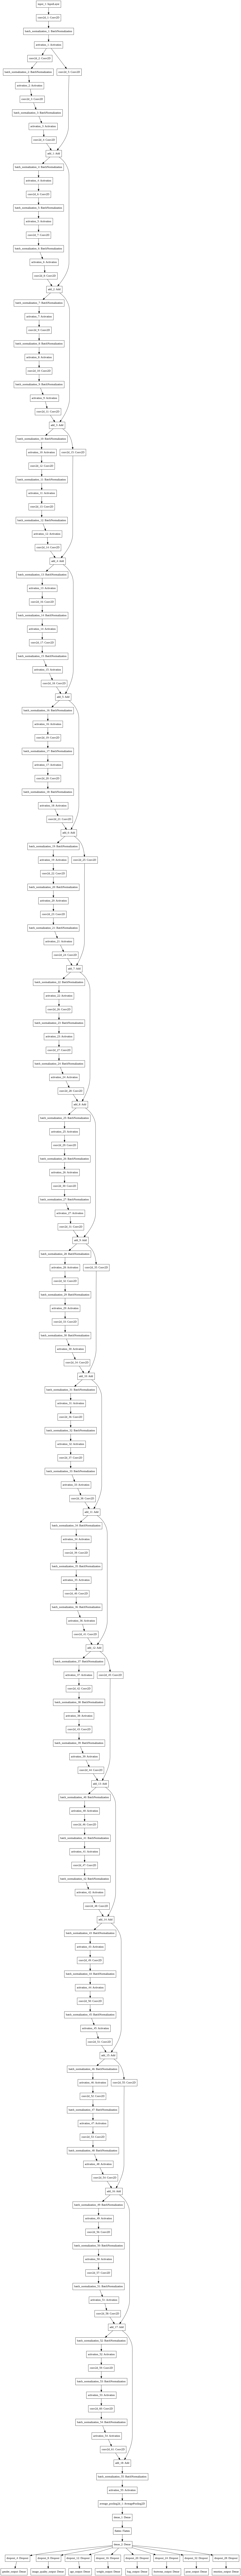

In [18]:
'''backbone = VGG16(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)'''

backbone = resnet_v2_x1
print("Inputs : ", backbone.input)
neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


"""def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck"""

def build_dense_tower(in_layer):
    neck = Dense(128, activation="relu")(in_layer)
    neck = Dropout(0.1)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.1)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.1)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.1)(in_layer)
    #neck = Dense(128, activation="relu")(neck)
    return neck



def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_dense_tower(neck))
image_quality = build_head("image_quality", build_dense_tower(neck))
age = build_head("age", build_dense_tower(neck))
weight = build_head("weight", build_dense_tower(neck))
bag = build_head("bag", build_dense_tower(neck))
footwear = build_head("footwear", build_dense_tower(neck))
emotion = build_head("emotion", build_dense_tower(neck))
pose = build_head("pose", build_dense_tower(neck))
print(image_quality)

model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)
model.summary()
plot_model(model)

In [0]:
# freeze backbone
#for layer in backbone.layers:
#	layer.trainable = False

In [0]:
 losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",

 }
 loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0, "weight_output":1.0}
 opt = SGD(lr=0.001, momentum=0.9)


# Model Compile

In [0]:
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    #loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [27]:
model.fit_generator(
      generator=train_gen,
      validation_data=valid_gen,
      use_multiprocessing=True,
      workers=8, 
      epochs= 20,
      verbose=1,callbacks=callbacks)

Epoch 1/20
1357/1357 [==============================] - 795s 586ms/step - loss: 13.3965 - gender_output_loss: 0.6774 - image_quality_output_loss: 0.9850 - age_output_loss: 1.4309 - weight_output_loss: 0.9924 - bag_output_loss: 0.9201 - footwear_output_loss: 0.9726 - pose_output_loss: 0.9343 - emotion_output_loss: 0.9132 - gender_output_acc: 0.5723 - image_quality_output_acc: 0.5462 - age_output_acc: 0.4000 - weight_output_acc: 0.6319 - bag_output_acc: 0.5592 - footwear_output_acc: 0.5361 - pose_output_acc: 0.6160 - emotion_output_acc: 0.7120 - val_loss: 13.2934 - val_gender_output_loss: 0.6567 - val_image_quality_output_loss: 0.9787 - val_age_output_loss: 1.4398 - val_weight_output_loss: 0.9791 - val_bag_output_loss: 0.9236 - val_footwear_output_loss: 0.9495 - val_pose_output_loss: 0.9144 - val_emotion_output_loss: 0.9343 - val_gender_output_acc: 0.5986 - val_image_quality_output_acc: 0.5469 - val_age_output_acc: 0.3705 - val_weight_output_acc: 0.6417 - val_bag_output_acc: 0.5446 - val

# Model Fit

In [28]:

results = model.evaluate_generator(train_gen, verbose=1)
dict(zip(model.metrics_names, results))


1357/1357 [==============================] - 224s 165ms/step


{'age_output_acc': 0.5717575534266764,
 'age_output_loss': 1.0725947796376032,
 'bag_output_acc': 0.7326823876197495,
 'bag_output_loss': 0.6441768555625361,
 'emotion_output_acc': 0.7406963890935888,
 'emotion_output_loss': 0.6959291853740889,
 'footwear_output_acc': 0.7482498157700811,
 'footwear_output_loss': 0.6065001569869506,
 'gender_output_acc': 0.8679071481208548,
 'gender_output_loss': 0.32264953815462666,
 'image_quality_output_acc': 0.6857958732498157,
 'image_quality_output_loss': 0.7270263214056862,
 'loss': 9.620789440045396,
 'pose_output_acc': 0.8279292557111275,
 'pose_output_loss': 0.43731787244054265,
 'weight_output_acc': 0.7016396462785557,
 'weight_output_loss': 0.76263346482966}

In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
#resnet_v2_x2=keras.models.load_model("/content/gdrive/My Drive/saved models/assign5_resnet50_i1.025.h5")
resnet_v2_x2=keras.models.load_model("/content/gdrive/My Drive/saved models/assign5_resnet50_i2.006.h5")